Note Book de Análise de preço imobiliario

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import kagglehub
import subprocess
import os

from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# 1. Importar dados

Opções de fonte da dados:

    - 'a': aluguel coletado no ZapImoveis em 27 de Out
    - 'c': compra coletado no ZapImoveis em 27 de Out

In [ ]:
fonte_dados = 'a'  # 'a', 'c', 'b'

if fonte_dados == 'a':
    df = pd.read_csv('aluguel_blumenau_25_10_27.csv')
elif fonte_dados == 'c':
    df = pd.read_csv('compra_blumenau_25_10_27.csv')
df


,Localidade,Endereco,M2,Preco,R$/M2,Latitude,Longitude,Tipo,Quarto,Banheiro,Vaga
0,Imóvel para alugar com 210 m² em Salto do Nort...,Rua Doutor Pedro Zimmermann,210.0,7500.0,35.714286,-26.859167,-49.086042,Imóvel,0,0,0
1,"Apartamento para alugar com 108 m², 3 quartos,...",Rua Benjamin Constant,108.0,2900.0,26.851852,-26.889516,-49.097449,Apartamento,3,2,2
2,Galpão/Depósito/Armazém para alugar com 450 m²...,NaN,450.0,7600.0,16.888889,-27.079758,-48.910080,Galpão/Depósito/Armazém,0,0,0
3,"Apartamento para alugar com 46 m², 2 quartos, ...",Rua Dois de Setembro,46.0,1400.0,30.434783,-26.876203,-49.087410,Apartamento,2,1,0
4,"Casa para alugar com 180 m², 5 quartos, 2 banh...",Rua João Gomes,180.0,2500.0,13.888889,-26.899939,-49.093511,Casa,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...
3121,"Apartamento para alugar com 45 m², 1 quarto, 1...",NaN,45.0,1700.0,37.777778,-27.079758,-48.910080,Apartamento,1,1,0
3122,"Apartamento para alugar com 45 m², 1 quarto, 1...",NaN,45.0,1950.0,43.333333,-27.079758,-48.910080,Apartamento,1,1,0
3123,"Apartamento para alugar com 45 m², 1 quarto, 1...",NaN,45.0,1950.0,43.333333,-27.079758,-48.910080,Apartamento,1,1,0
3124,"Apartamento para alugar com 90 m², 2 quartos, ...",NaN,90.0,1790.0,19.888889,-27.079758,-48.910080,Apartamento,2,2,1


# 2. Limpa os dados

Drop colunas indesejadas

In [ ]:
df.drop(columns=['Localidade', 'Endereco', 'R$/M2'], inplace=True)
df

,M2,Preco,Latitude,Longitude,Tipo,Quarto,Banheiro,Vaga
0,210.0,7500.0,-26.859167,-49.086042,Imóvel,0,0,0
1,108.0,2900.0,-26.889516,-49.097449,Apartamento,3,2,2
2,450.0,7600.0,-27.079758,-48.910080,Galpão/Depósito/Armazém,0,0,0
3,46.0,1400.0,-26.876203,-49.087410,Apartamento,2,1,0
4,180.0,2500.0,-26.899939,-49.093511,Casa,5,2,2
...,...,...,...,...,...,...,...,...
3121,45.0,1700.0,-27.079758,-48.910080,Apartamento,1,1,0
3122,45.0,1950.0,-27.079758,-48.910080,Apartamento,1,1,0
3123,45.0,1950.0,-27.079758,-48.910080,Apartamento,1,1,0
3124,90.0,1790.0,-27.079758,-48.910080,Apartamento,2,2,1


Exclui os tipos de Imóveis indesejados

In [22]:
tipos_list = df['Tipo'].unique()
print(f'{tipos_list}')

['Imóvel' 'Apartamento' 'Galpão/Depósito/Armazém' 'Casa' 'Cobertura'
 'Sala/Conjunto' 'Sobrado' 'Ponto' 'Prédio/Edificio' 'Lote/Terreno'
 'Prédio/Edifício' 'Kitnet/Conjugado' 'Fazenda/Sítio/Chácara' 'Loft'
 'Flat' 'Garagem']


In [23]:
tipos_desejados = ['Cobertura', 'Apartamento', 'Casa', 'Sobrado', 'Kitnet/Conjugado']
df = df[df['Tipo'].isin(tipos_desejados)]
print(f'{df["Tipo"].unique()} \n Com tamanho {df.shape}')

['Apartamento' 'Casa' 'Cobertura' 'Sobrado' 'Kitnet/Conjugado'] 
 Com tamanho (1229, 8)


Exclui Out Liers

In [24]:
if fonte_dados == 'c':
    df = df[df['Preco'] < 10000000]
elif fonte_dados == 'a':
    df = df[df['Preco'] < 20000]

df = df[df['M2'] < 1000]
df = df[df['Banheiro'] < 10]
df = df[df['Vaga'] < 20]
df.reset_index(inplace=True, drop=True)
print(f'Após exclusão de outliers, tamanho {df.shape}')

Após exclusão de outliers, tamanho (1218, 8)


Exclui NA

In [25]:
print(df.isna().sum())
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

M2            0
Preco         0
Latitude     14
Longitude    14
Tipo          0
Quarto        0
Banheiro      0
Vaga          0
dtype: int64


Mostra o Box Plot dos dados

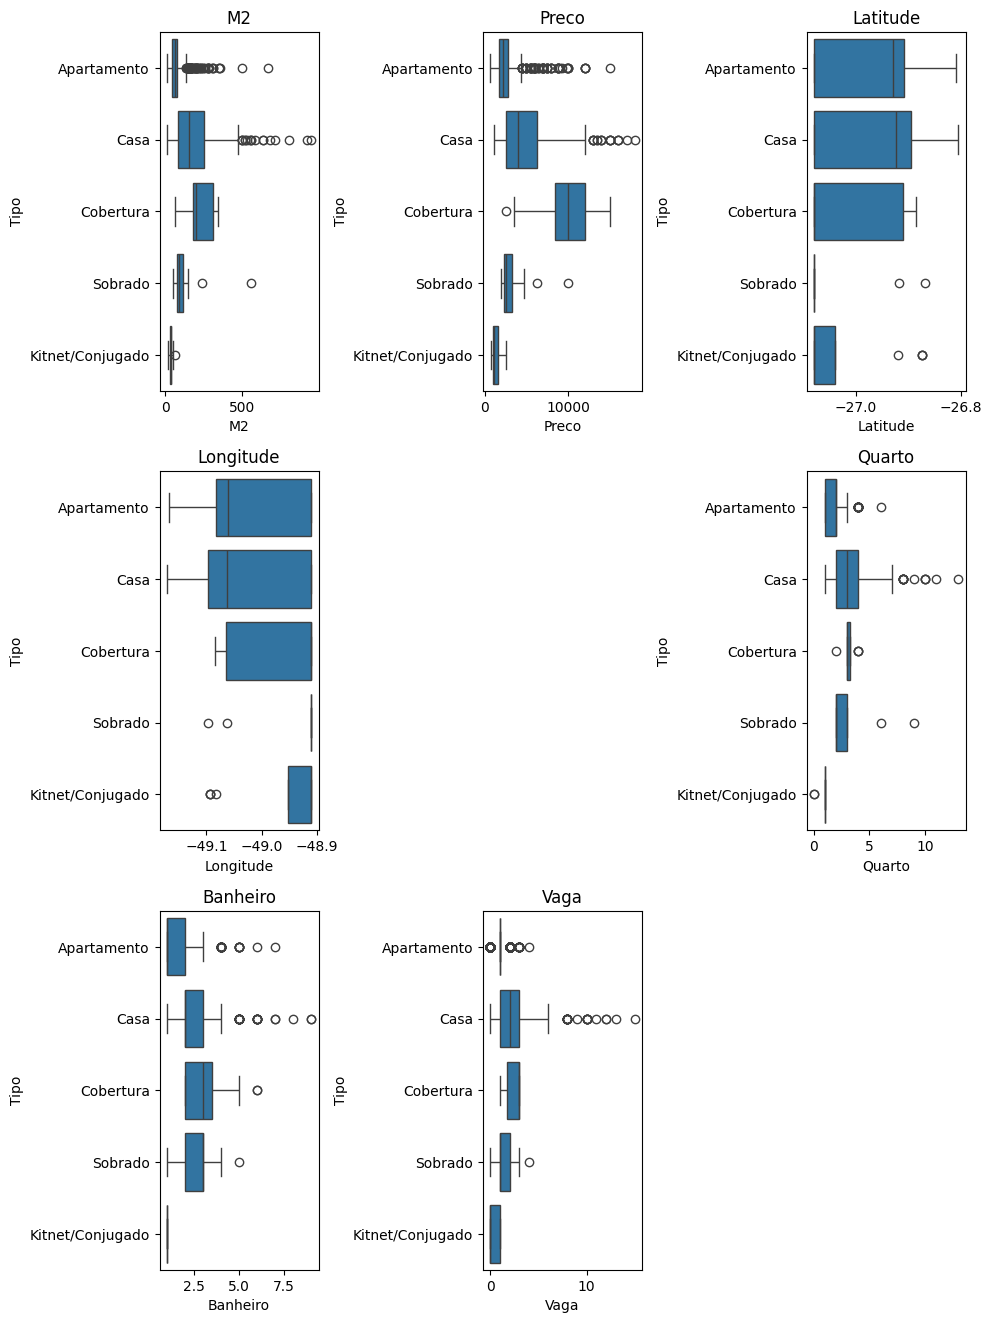

In [26]:
len_col = len(df.columns)
plt.figure(figsize=(10, len_col*5/3))


for idx, col in enumerate(df.columns):
    if col != 'Tipo':
        plt.subplot(int(len_col/3) + 1, 3, idx+1)

        sns.boxplot(data=df, x=col, y='Tipo')
        plt.title(f"{col}")
    #else:
plt.tight_layout()

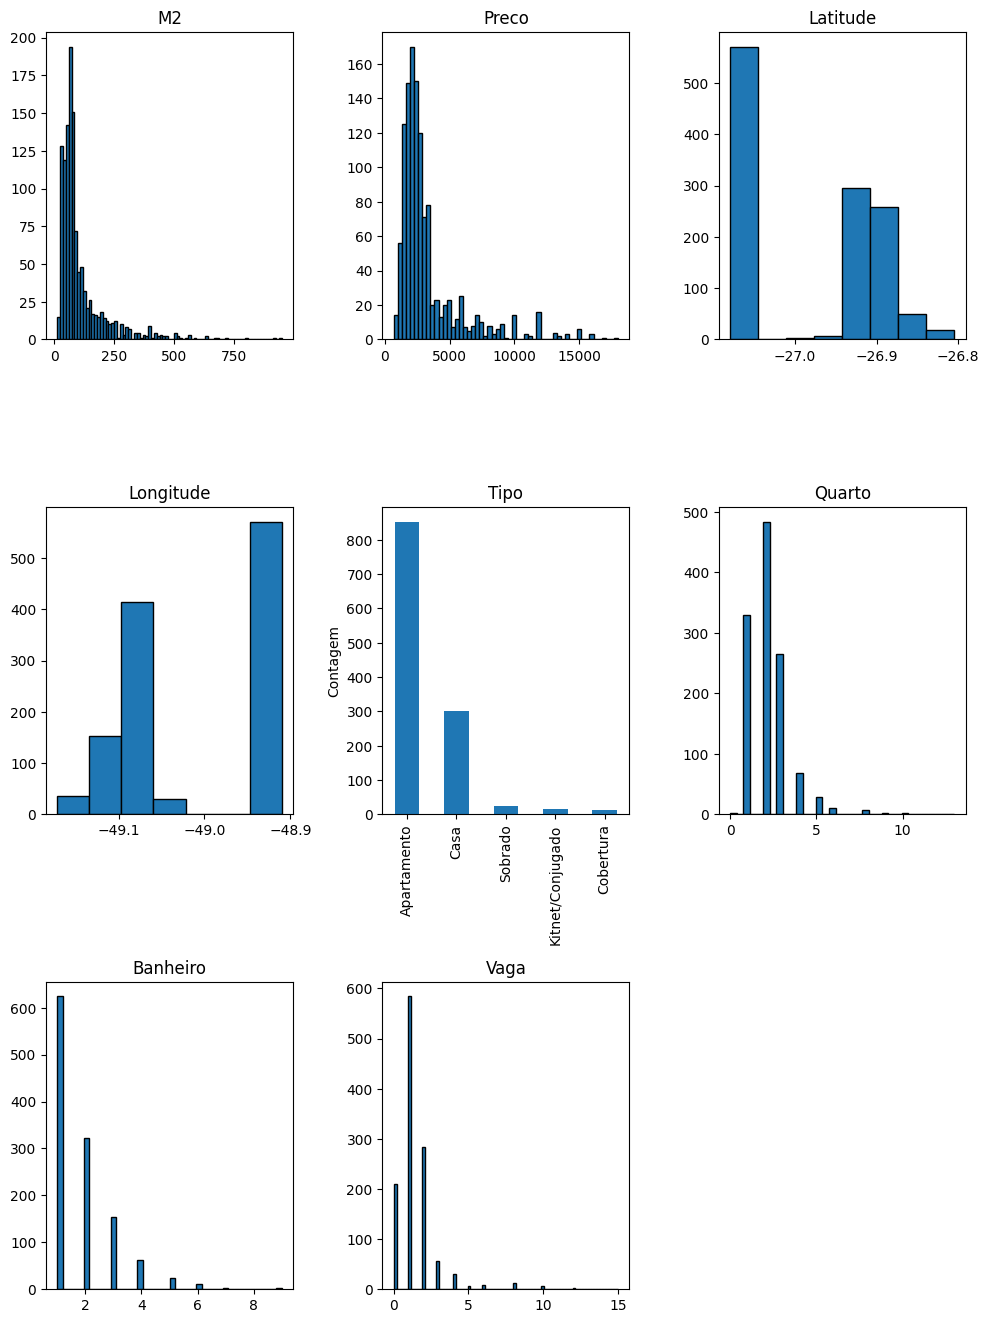

In [27]:
plt.figure(figsize=(10, len_col*5/3))

for idx, col in enumerate(df.columns):

    if col != 'Tipo':
        x = df[col].dropna()
        plt.subplot(int(len_col/3) + 1, 3, idx+1)
        bins = int((np.max(x) - np.min(x)) / (2 * (np.percentile(x, 75) - np.percentile(x, 25)) * len(x)**(-1/3)))
        plt.hist(x, bins=bins, edgecolor="black")
        plt.title(f"{col}")
    else:
        plt.subplot(int(len_col/3) + 1, 3, idx+1)
        df[col].value_counts(dropna=False).plot(kind="bar")
        plt.title(f"{col}")
        plt.ylabel("Contagem")
plt.tight_layout()

Transforma as colunas categóricas em One Hot Encoder

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df[df.columns.difference(['Preco'])], df['Preco'], test_size=0.2, stratify=df['Tipo'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42)

X_train_val.reset_index(inplace=True, drop=True)
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train_val.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_val.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

In [29]:
def convert_OHE(df):
    encoder = OneHotEncoder(sparse_output=False) 
    encoded = encoder.fit_transform(df['Tipo'].values.reshape(-1, 1))
    df_encoded = pd.DataFrame(
        encoded, 
        columns=encoder.get_feature_names_out(['Tipo'])
    )
    df = pd.concat([df, df_encoded], axis=1)
    df.drop(columns=['Tipo'], inplace=True)
    return df

In [31]:
if fonte_dados == 'a' or fonte_dados == 'c':
    
    X_train_val = convert_OHE(X_train_val)
    X_train = convert_OHE(X_train)
    X_val = convert_OHE(X_val)
    X_test = convert_OHE(X_test)

# 3. Aplica os algoritmos

## 3.1 xgBoost

In [32]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'XGBoost - MAE: {mae}, MSE: {mse}, MAP: {map}')

XGBoost - MAE: 773.1268171255025, MSE: 1607869.0263563509, MAP: 0.23462831956705937


In [33]:
pd.Series(xgb_model.feature_importances_, index=X_test.columns).sort_values(ascending=False)

M2                       0.373760
Tipo_Casa                0.128960
Tipo_Cobertura           0.091479
Vaga                     0.088296
Banheiro                 0.084702
Tipo_Apartamento         0.061357
Longitude                0.060287
Quarto                   0.046731
Tipo_Kitnet/Conjugado    0.029331
Latitude                 0.026210
Tipo_Sobrado             0.008887
dtype: float32

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 5, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.3),
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'tree_method': trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist'])      
    }

    xgb_model = xgb.XGBRegressor(**param)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    map = mean_absolute_percentage_error(y_val, y_pred)
    return map

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
best_params_xgb = study.best_params
print(f'Best parameters: {best_params_xgb}')

[I 2025-11-04 01:17:52,736] A new study created in memory with name: no-name-c344860d-530c-4d7c-b0f4-73f751442597
[I 2025-11-04 01:18:16,744] Trial 0 finished with value: 267326.957449262 and parameters: {'n_estimators': 423, 'max_depth': 15, 'learning_rate': 0.15963224616620603, 'booster': 'dart', 'tree_method': 'exact'}. Best is trial 0 with value: 267326.957449262.
[I 2025-11-04 01:18:23,393] Trial 1 finished with value: 245031.33642758304 and parameters: {'n_estimators': 273, 'max_depth': 7, 'learning_rate': 0.11507536848217594, 'booster': 'dart', 'tree_method': 'exact'}. Best is trial 1 with value: 245031.33642758304.
[I 2025-11-04 01:18:24,086] Trial 2 finished with value: 263819.7269733049 and parameters: {'n_estimators': 218, 'max_depth': 12, 'learning_rate': 0.15396775025844223, 'booster': 'gbtree', 'tree_method': 'hist'}. Best is trial 1 with value: 245031.33642758304.
[I 2025-11-04 01:18:24,332] Trial 3 finished with value: 260470.40825357471 and parameters: {'n_estimators':

Best parameters: {'n_estimators': 188, 'max_depth': 7, 'learning_rate': 0.16333019414603758, 'booster': 'dart', 'tree_method': 'exact'}


In [ ]:
xgb_model = xgb.XGBRegressor(**best_params_xgb)
xgb_model.fit(X_train_val, y_train_val)
y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'XGBoost - MAE: {mae}, MSE: {mse}, MAP: {map}')
print(pd.Series(xgb_model.feature_importances_, index=X_test.columns).sort_values(ascending=False))

XGBoost - MAE: 246204.8555033186, MSE: 218569713695.1147, MAP: 0.2668844402595169
Tipo_Casa                0.408469
M2                       0.136425
Tipo_Sobrado             0.104126
Tipo_Apartamento         0.100369
Banheiro                 0.073208
Vaga                     0.057235
Tipo_Cobertura           0.043554
Quarto                   0.038216
Longitude                0.021609
Latitude                 0.015740
Tipo_Flat                0.000899
Tipo_Kitnet/Conjugado    0.000151
dtype: float32


## 3.2 Random Forest

In [34]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'Random Forest - MAE: {mae}, MSE: {mse}, MAP: {map}')

Random Forest - MAE: 735.5788452056581, MSE: 1382607.2894433143, MAP: 0.23559436632685035


In [35]:
pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False)

M2                       0.757563
Banheiro                 0.060020
Longitude                0.048182
Vaga                     0.046866
Latitude                 0.032455
Quarto                   0.023364
Tipo_Cobertura           0.015448
Tipo_Casa                0.009529
Tipo_Apartamento         0.005838
Tipo_Kitnet/Conjugado    0.000379
Tipo_Sobrado             0.000355
dtype: float64

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = RandomForestRegressor(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    map = mean_absolute_percentage_error(y_val, y_pred)
    return map

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
best_params_rf = study.best_params
print(f'Best parameters: {best_params_rf}')

[I 2025-11-04 02:17:32,132] A new study created in memory with name: no-name-c2c8ea2e-f75e-483d-8bd5-82ce2d173f58
[I 2025-11-04 02:17:33,708] Trial 0 finished with value: 290996.2032965737 and parameters: {'n_estimators': 503, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 0 with value: 290996.2032965737.
[I 2025-11-04 02:17:37,758] Trial 1 finished with value: 250304.4837142957 and parameters: {'n_estimators': 555, 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 250304.4837142957.
[I 2025-11-04 02:17:39,918] Trial 2 finished with value: 266849.77714387735 and parameters: {'n_estimators': 491, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 9}. Best is trial 1 with value: 250304.4837142957.
[I 2025-11-04 02:17:41,792] Trial 3 finished with value: 347075.6381394832 and parameters: {'n_estimators': 836, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 1 with value: 25030

Best parameters: {'n_estimators': 397, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1}


In [ ]:
model = RandomForestRegressor(**best_params_rf)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
map = mean_absolute_percentage_error(y_test, y_pred)
print(f'Random Forest - MAE: {mae}, MSE: {mse}, MAP: {map}')
print(pd.Series(model.feature_importances_, index=X_test.columns).sort_values(ascending=False))

Random Forest - MAE: 261219.3423411922, MSE: 232370786843.97815, MAP: 0.2818561061091983
M2                       0.573230
Banheiro                 0.159559
Vaga                     0.075401
Tipo_Casa                0.050411
Quarto                   0.041780
Latitude                 0.034922
Longitude                0.033787
Tipo_Apartamento         0.019707
Tipo_Cobertura           0.006100
Tipo_Sobrado             0.005066
Tipo_Kitnet/Conjugado    0.000029
Tipo_Flat                0.000007
dtype: float64


# 4. Previsão do valor

In [36]:
x = pd.DataFrame(columns=X_test.columns)
x.loc[0] = {'Banheiro': 3, 'Latitude': -26.908588736369982, 'Longitude': -49.095866513551584, 'M2': 100, 'Quarto': 2, 'Vaga': 1,
            'Tipo_Apartamento': 0, 'Tipo_Casa': 0, 'Tipo_Cobertura': 0, 'Tipo_Flat': 0,
            'Tipo_Kitnet/Conjugado': 0, 'Tipo_Sobrado': 1}
y_pred_xgb = xgb_model.predict(x)

y_pred_rf = model.predict(x)

print(f'Previsão XGBoost: {(y_pred_xgb[0]/1000):.2f} mil')
print(f'Previsão Random Forest: {(y_pred_rf[0]/1000):.2f} mil')

Previsão XGBoost: 3.23 mil
Previsão Random Forest: 2.95 mil
